In [1]:
# https://scib-metrics.readthedocs.io/en/stable/notebooks/lung_example.html
print('start')

start


In [2]:
from interpretable_ssl.immune.trainer import ImmuneTrainer
trainer = ImmuneTrainer(self_supervised=True)

loading data
training with number of prototypes : ssl-num-prot-32_hidden-16_bs-256_train-ratio-0.5.pth


/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.4.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
latent, prot_dist, projections = trainer.get_ssl_representations()

In [6]:
adata = trainer.dataset.adata
adata.obsm['barlow'] = latent.detach().cpu().numpy()
adata.obsm['prot_dist'] = prot_dist.detach().cpu().numpy()
adata.obsm['projections'] = projections.detach().cpu().numpy()

In [8]:
import scanpy as sc
latent_dims = trainer.latent_dims
sc.tl.pca(adata, n_comps=latent_dims, use_highly_variable=True)
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

In [9]:
import scvi

scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, gene_likelihood="nb", n_layers=2, n_latent=latent_dims)
vae.train()
adata.obsm["scVI"] = vae.get_latent_representation()

Global seed set to 0
/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance

Epoch 239/239: 100%|██████████| 239/239 [06:56<00:00,  1.73s/it, loss=1.1e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=239` reached.


Epoch 239/239: 100%|██████████| 239/239 [06:56<00:00,  1.74s/it, loss=1.1e+03, v_num=1]


In [10]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)
lvae.train(max_epochs=20, n_samples_per_label=100)
adata.obsm["scANVI"] = lvae.get_latent_representation()

INFO     Training for 20 epochs.                                                                                   


/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-7f7d366f-7513-5448-b61b-32bfe54672cc]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 20/20: 100%|██████████| 20/20 [01:23<00:00,  3.93s/it, loss=1.16e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [01:23<00:00,  4.17s/it, loss=1.16e+03, v_num=1]


In [11]:
from scib_metrics.benchmark import Benchmarker

bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["Unintegrated","scVI", "scANVI", "barlow", "prot_dist", "projections"],
)
bm.benchmark()

Metrics:  60%|██████    | 6/10 [00:24<00:12,  3.18s/it, Batch correction: kbet_per_label]/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/fatemehs.hashemig/miniconda3/envs/interp

In [12]:
from rich import print

df = bm.get_results(min_max_scale=False)
df

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
Unintegrated,0.607787,0.588969,0.388528,0.542957,0.992112,0.769013,0.050957,0.105152,0.770409,0,0.339106,0.624071,0.510085
scVI,0.662271,0.668302,0.408149,0.567238,0.996985,0.857651,0.223539,0.226988,0.87112,0.942495,0.624359,0.660589,0.646097
scANVI,0.687986,0.722071,0.498498,0.602816,0.998304,0.858586,0.250802,0.265349,0.889904,0.919804,0.636889,0.701935,0.675916
barlow,0.486566,0.002276,0.000506,0.328408,0.853782,0.863251,0.304746,0.33757,0.300611,0.996946,0.560625,0.334308,0.424834
prot_dist,0.463726,0.005693,0.001432,0.285566,0.838047,0.785221,0.324837,0.426661,0.26825,0.993458,0.559685,0.318893,0.41521
projections,0.473264,0.005617,0.001411,0.300127,0.79781,0.831261,0.392783,0.314979,0.127044,0.9935,0.531914,0.315646,0.402153
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scib_metrics/benchmark/_core.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scib_metrics/benchmark/_core.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scib_metrics/benchmark/_core.py:268: FutureWarnin

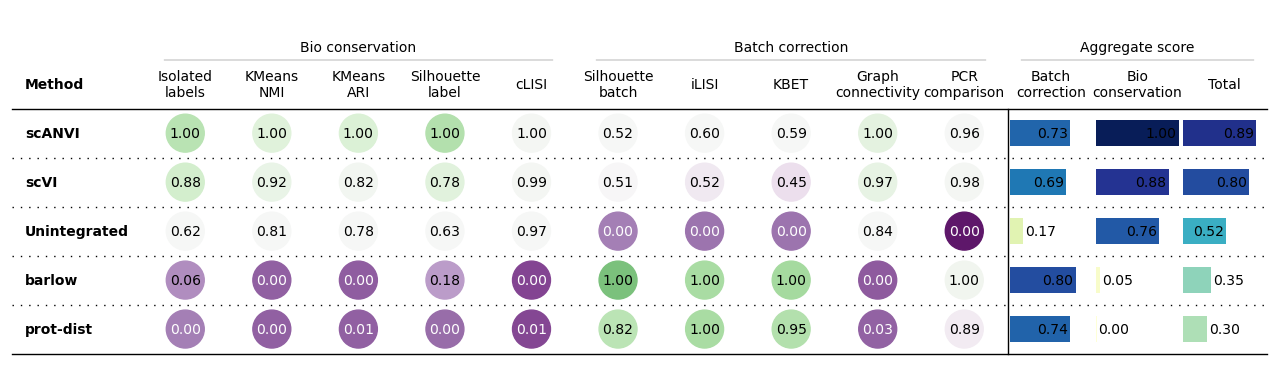

In [12]:
bm.plot_results_table()


In [13]:
from rich import print

df = bm.get_results(min_max_scale=False)
df

Isolated labels        KMeans NMI        KMeans ARI  \
Embedding                                                            
Unintegrated          0.607787          0.588969          0.388528   
scVI                  0.662271          0.668302          0.408149   
scANVI                0.687986          0.722071          0.498498   
barlow                0.486493          0.022694          0.006145   
prot-dist             0.474405          0.021718          0.010648   
Metric Type   Bio conservation  Bio conservation  Bio conservation   

              Silhouette label             cLISI  Silhouette batch  \
Embedding                                                            
Unintegrated          0.542957          0.992112          0.769013   
scVI                  0.567238          0.996985          0.857651   
scANVI                0.602816          0.998304          0.858586   
barlow                0.468892          0.799973          0.942723   
prot-dist             0.439761          0.802472          0.911218   
Metric Type   Bio conservation  Bio conservation  Batch correction   

                         iLISI              KBET Graph connectivity  \
Embedding                                                             
Unintegrated          0.050957          0.105152           0.770409   
scVI                  0.223539          0.226988            0.87112   
scANVI                0.250802          0.265349           0.889904   
barlow                0.382552          0.374979           0.143846   
prot-dist             0.382299           0.36094           0.162587   
Metric Type   Batch correction  Batch correction   Batch correction   

                PCR comparison Batch correction Bio conservation  \
Embedding                                                          
Unintegrated                 0         0.339106         0.624071   
scVI                  0.942495         0.624359         0.660589   
scANVI                0.919804         0.636889         0.701935   
barlow                0.961871         0.561194         0.356839   
prot-dist             0.852939         0.533997         0.349801   
Metric Type   Batch correction  Aggregate score  Aggregate score   

                        Total  
Embedding                      
Unintegrated         0.510085  
scVI                 0.646097  
scANVI               0.675916  
barlow               0.438581  
prot-dist            0.423479  
Metric Type   Aggregate score

In [14]:
df

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
Unintegrated,0.607787,0.588969,0.388528,0.542957,0.992112,0.769013,0.050957,0.105152,0.770409,0,0.339106,0.624071,0.510085
scVI,0.662271,0.668302,0.408149,0.567238,0.996985,0.857651,0.223539,0.226988,0.87112,0.942495,0.624359,0.660589,0.646097
scANVI,0.687986,0.722071,0.498498,0.602816,0.998304,0.858586,0.250802,0.265349,0.889904,0.919804,0.636889,0.701935,0.675916
barlow,0.486493,0.022694,0.006145,0.468892,0.799973,0.942723,0.382552,0.374979,0.143846,0.961871,0.561194,0.356839,0.438581
prot-dist,0.474405,0.021718,0.010648,0.439761,0.802472,0.911218,0.382299,0.36094,0.162587,0.852939,0.533997,0.349801,0.423479
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [15]:
df.transpose()


Embedding,Unintegrated,scVI,scANVI,barlow,prot-dist,Metric Type
Isolated labels,0.607787,0.662271,0.687986,0.486493,0.474405,Bio conservation
KMeans NMI,0.588969,0.668302,0.722071,0.022694,0.021718,Bio conservation
KMeans ARI,0.388528,0.408149,0.498498,0.006145,0.010648,Bio conservation
Silhouette label,0.542957,0.567238,0.602816,0.468892,0.439761,Bio conservation
cLISI,0.992112,0.996985,0.998304,0.799973,0.802472,Bio conservation
Silhouette batch,0.769013,0.857651,0.858586,0.942723,0.911218,Batch correction
iLISI,0.050957,0.223539,0.250802,0.382552,0.382299,Batch correction
KBET,0.105152,0.226988,0.265349,0.374979,0.36094,Batch correction
Graph connectivity,0.770409,0.87112,0.889904,0.143846,0.162587,Batch correction
PCR comparison,0,0.942495,0.919804,0.961871,0.852939,Batch correction


In [16]:
def plot_umap(rep):
    sc.pp.neighbors(adata, use_rep=rep)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['cell_type'])

/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


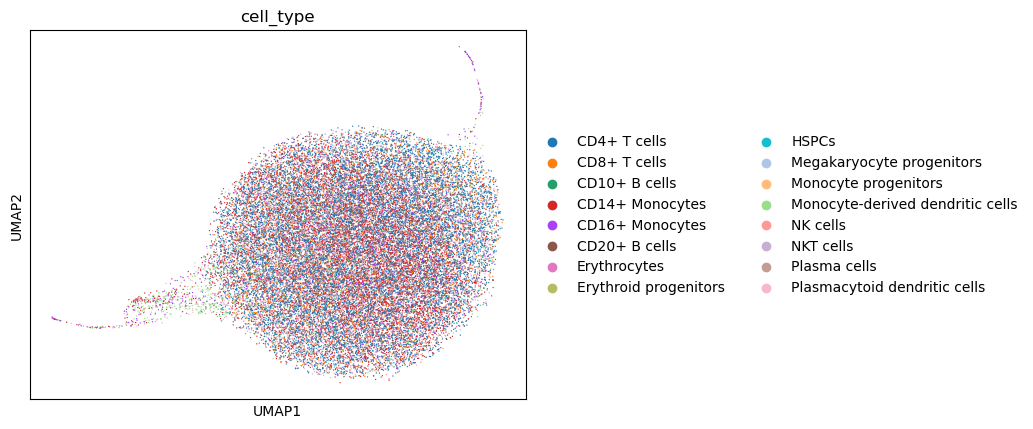

In [17]:
plot_umap('barlow')

/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


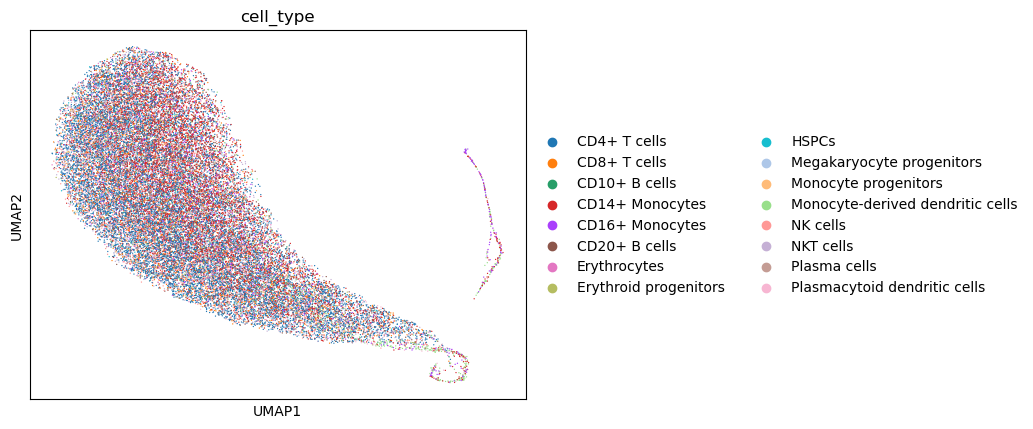

In [18]:
plot_umap('prot-dist')

/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


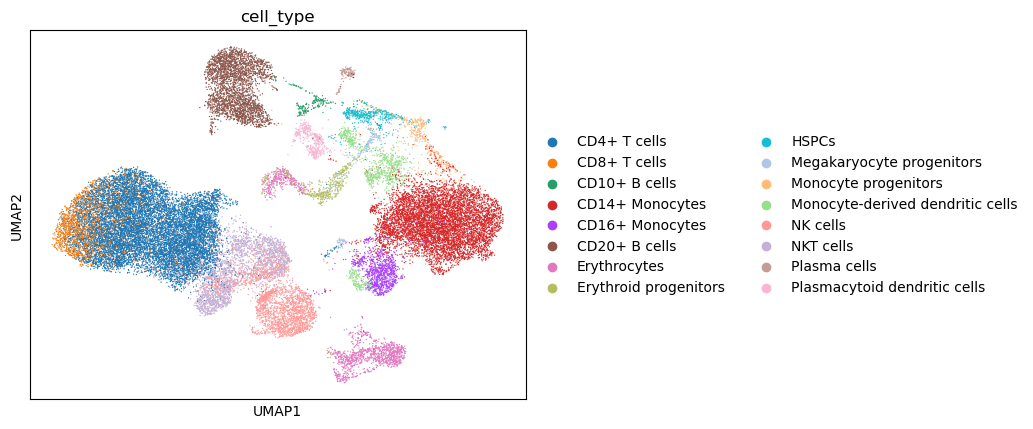

In [19]:
plot_umap('scVI')

/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


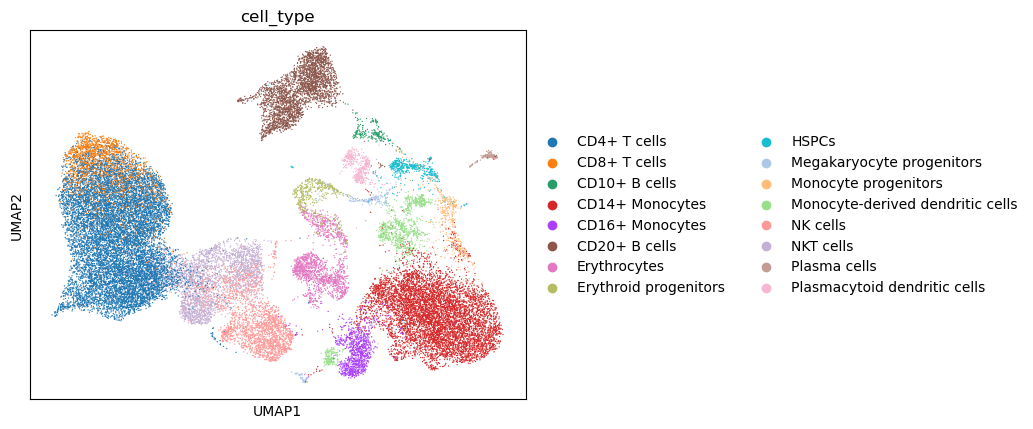

In [20]:
plot_umap('scANVI')

/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


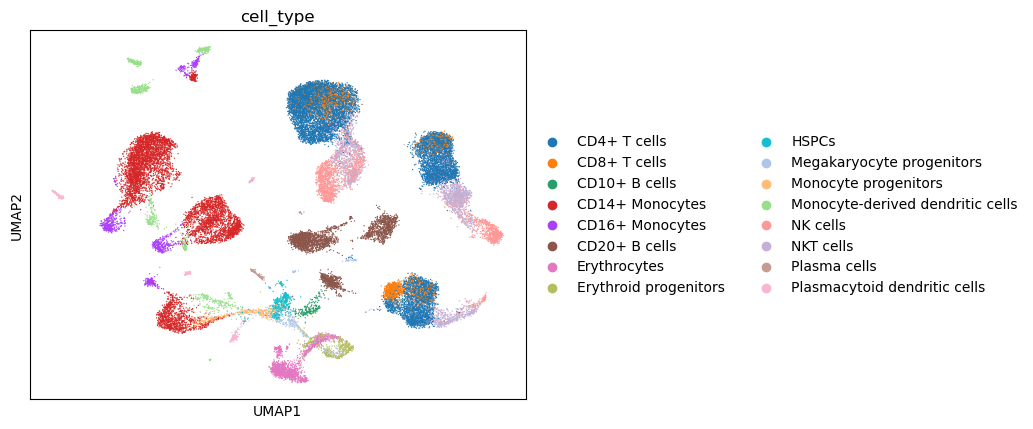

In [21]:
plot_umap('X_pca')

In [22]:
adata.obsm['x'] = adata.X

/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


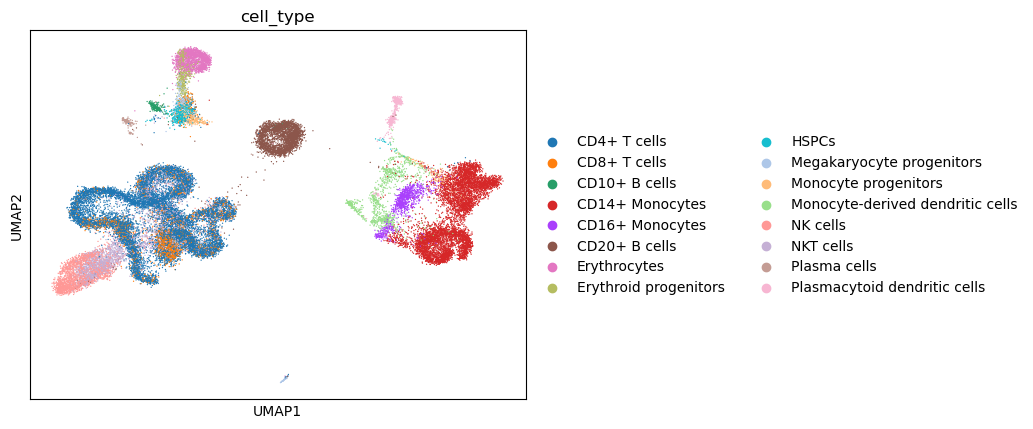

In [23]:
plot_umap('x')

In [25]:
prot_dist.shape

torch.Size([33506, 16])

In [26]:
projected = model.barlow_model.projector(prot_dist)

In [27]:
projected.shape

torch.Size([33506, 32])

/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


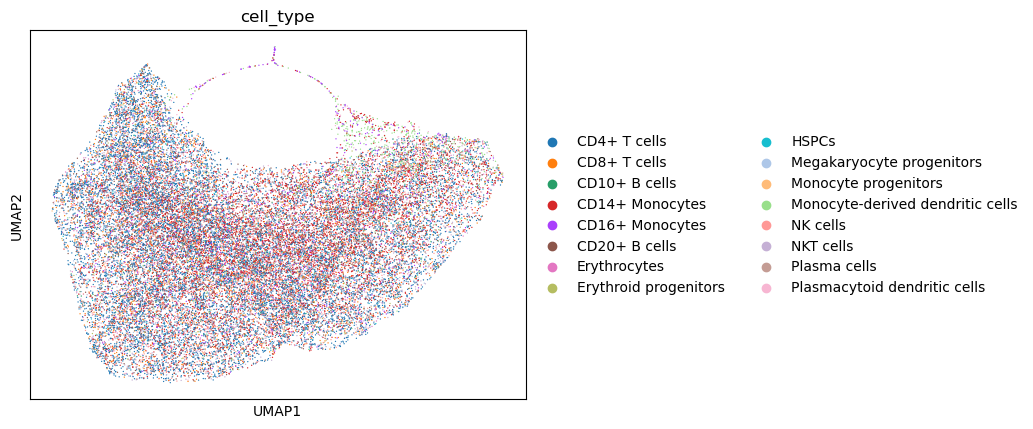

In [30]:
adata.obsm['projected'] = projected.detach().cpu().numpy()
plot_umap('projected')